# 0.1 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

# 0.2 하이퍼파라미터 셋팅

In [2]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. MNIST train, test dataset 가져오기

In [4]:
# MNIST dataset
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

# 2. 대략적인 데이터 형태

mnist_train 길이:  60000
mnist_test 길이:  10000
image data 형태:  torch.Size([1, 28, 28])
label:  5


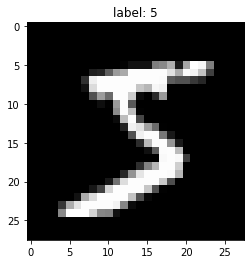

In [5]:
print("mnist_train 길이: ", len(mnist_train))
print("mnist_test 길이: ", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print("image data 형태: ", image.size())
print("label: ",label)

# 그리기
img = image.numpy() #image 타입을 numpy로 변환 (1,28,28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

# 3. 데이터 로드 함수

학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, # mnist_train 을 트레인 시키자
                                            batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True) # batch_size 만큼 나눌 때 나머지는 버림

test_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                            batch_size=batch_size,
                                          shuffle=False, # test 에서는 shuffle 하지 않음
                                          drop_last=True)

# 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기: 100


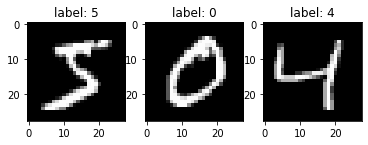

[1]
한 번에 로드되는 데이터 크기: 100


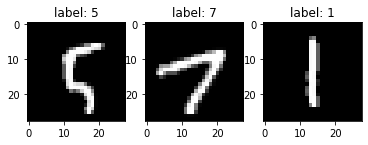

[2]
한 번에 로드되는 데이터 크기: 100


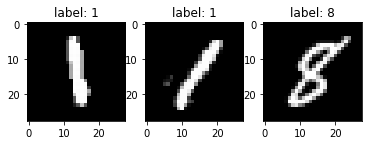

[3]
한 번에 로드되는 데이터 크기: 100


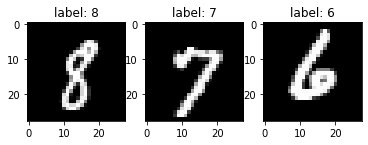

[4]
한 번에 로드되는 데이터 크기: 100


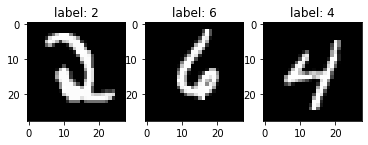

[5]
한 번에 로드되는 데이터 크기: 100


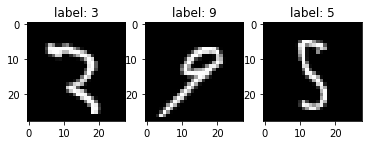

In [7]:
n = 3 # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼
    if i > 5:
        break
        
    print ("[%d]"%i)
    print("한 번에 로드되는 데이터 크기:", len(imgs))
    
    # 그리기
    for j in range(n):
        img = imgs[j].numpy() # image 타입을 numpy 로 변환 (1,28,28)
        img = img.reshape((img.shape[1], img.shape[2])) # (1,28,28) -> (28,28)
#         print(img.shape)
        
        plt.subplot(1,n,j+1) # (1,3) 형태 플랏의 j 번째 자리에 그리겠다
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

# 4. 모델 선언

In [8]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers=num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # -----
        # input tensor : (batc_size, seq_length, input_size)
        # x: (100, 28, 28)
        # print('x: ', x.shape)
        
        # -----
        # hidden state tensor: (# of layers, batch_size, hidden_size)
        # h: (2, 100, 128)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # -----
        # Forward propagate LSTM
        # output tensor: (batch_size, seq_length, hidden_size)
        # out: (100, 28, 128)
        # print('out: ', out.shape)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # -----
        # 28번째 output layer : (bs, hidden_size)
        # out[:, -1, :]: (100, 128)
        # print('out[-1]: ', out.shape)
        
        out = self.fc(out[:, -1, :])
        
        # y^: (batch_size, num_classes)
        # y_pred: (100, 10)
        #print('out: ', out.shape)
        
        return out

In [9]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [10]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        # x: (batch_size, 1, seq_length, input_size)) -> (batch_size, seq_length,  input_size)
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)
        
        # y: (batch_size, num_classes)
        label = labels.to(device) # y # Variable(labels)
        #label = Variable(labels).cuda()
        # .cuda() : GPU에 로드되기 위함. 만약, CPU로 설정되어있으면 에러
        
        # Forward prop.
        output = imodel(img) # (batch_size, num_classes)
        _, output_index = torch.max(output, 1) # (batch_size, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    #print('Accuracy of Test Data: {}',format(100*correct/total))
    return (100*correct/total).numpy() # tensor -> numpy

In [11]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 10.22


# 5. loss, optimizer

In [12]:
# Loss and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 6. 학습

In [13]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, [imgs, labels] in enumerate(train_loader):
        # x: (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)
        
        # y: (batch_size, num_classes)
        label = labels.to(device) # y # Variable(labels)
        
        # Forward prop.
        outputs = model(img)
        loss = loss_func(outputs, label)
        
        # Backward prop. & optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Accr: {:.2f}'
                  .format(epoch+1, num_epochs, i+1, total_step,
                         loss.item(),
                         ComputeAccr(test_loader, model)))

Epoch [1/2], Step[100/600], Loss: 0.6488, Accr: 79.48
Epoch [1/2], Step[200/600], Loss: 0.2355, Accr: 87.82
Epoch [1/2], Step[300/600], Loss: 0.3294, Accr: 93.56
Epoch [1/2], Step[400/600], Loss: 0.0902, Accr: 95.22
Epoch [1/2], Step[500/600], Loss: 0.2776, Accr: 95.74
Epoch [1/2], Step[600/600], Loss: 0.1241, Accr: 95.81
Epoch [2/2], Step[100/600], Loss: 0.1626, Accr: 97.01
Epoch [2/2], Step[200/600], Loss: 0.1601, Accr: 96.80
Epoch [2/2], Step[300/600], Loss: 0.0934, Accr: 97.79
Epoch [2/2], Step[400/600], Loss: 0.2190, Accr: 97.37
Epoch [2/2], Step[500/600], Loss: 0.1433, Accr: 97.58
Epoch [2/2], Step[600/600], Loss: 0.1129, Accr: 97.75


# 7. 테스트

In [14]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.75


# 8. 학습된 파라미터 저장

In [15]:
netname = './nets/rnn_weight.pkl'
torch.save(model, netname, )

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 9. 학습된 파라미터 로드
실무에서 학습된(pretrained) 파라미터 로드하고 싶다면: 5,6,8 과정 생략한 채 실행

In [16]:
netname = './nets/rnn_weight.pkl'
model = torch.load(netname)

In [17]:
print("Accuracy of Test Data: %.2f" %ComputeAccr(test_loader, model))

Accuracy of Test Data: 97.75
